전세계 최대 헤지펀드인 Bridgewater Associates의 창업자 Ray Dalio가 만든 전략이 있습니다. 주식 30%, 중기 국채 15%, 장기 국채 40%, 금 7.5%, 원자재 7.5% 비율로 가져갑니다. 주식/국채/금/현금으로 만든 영구 포트폴리오나 Goldenbutterfly(황금나비) 전략과 비슷하지만, 현금을 가져가지 않는 대신 원자재를 가져가 기대 이상의 인플레이션 대응에 더 큰 비중을 두었습니다.

In [23]:
import pandas as pd
import pandas_datareader.data as web
import datetime
import backtrader as bt
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pyfolio as pf
import quantstats
import math
plt.rcParams["figure.figsize"] = (10, 6) # (w, h)

원자재 ETF인 GSG 데이터가 2006-07-21부터 구해지므로 그때부터 시작합니다.

In [2]:
start = '2006-07-21'
end = '2021-04-23'

vti = web.DataReader('VTI', 'yahoo', start, end)['Adj Close'].to_frame("vti_Close")
ief = web.DataReader('IEF', 'yahoo', start, end)['Adj Close'].to_frame("ief_Close")
tlt = web.DataReader('TLT', 'yahoo', start, end)['Adj Close'].to_frame("tlt_Close")
gld = web.DataReader('GLD', 'yahoo', start, end)['Adj Close'].to_frame("gld_Close")
gsg = web.DataReader('GSG', 'yahoo', start, end)['Adj Close'].to_frame("gsg_Close")

In [3]:
gsg.head()

,gsg_Close
Date,
2006-07-21,49.250000
2006-07-24,49.700001
2006-07-25,49.250000
2006-07-26,49.619999
2006-07-27,50.150002


일단 모델 포트폴리오로, 매일 비중을 맞추는 것으로 생각하고 만듭니다. 거래비용은 생략합니다.

In [4]:
vti_return = vti.pct_change(periods=1)
ief_return = ief.pct_change(periods=1)
tlt_return = tlt.pct_change(periods=1)
gld_return = gld.pct_change(periods=1)
gsg_return = gsg.pct_change(periods=1)

df_return = pd.concat([vti_return, ief_return, tlt_return, gld_return, gsg_return], axis=1)

df_return.head()

,vti_Close,ief_Close,tlt_Close,gld_Close,gsg_Close
Date,,,,,
2006-07-20,NaN,NaN,NaN,NaN,NaN
2006-07-21,-0.007953,-0.000618,-0.001870,-0.013272,NaN
2006-07-24,0.019468,0.000000,-0.000586,-0.009237,0.009137
2006-07-25,0.003370,-0.000989,-0.002932,0.006706,-0.009054
2006-07-26,0.002719,0.002475,0.003645,0.007311,0.007513


In [5]:
df_return['AllSeason_return'] = df_return['vti_Close']*0.3+df_return['ief_Close']*0.15+df_return['tlt_Close']*0.4+df_return['gld_Close']*0.075+df_return['gsg_Close']*0.075
df_return.head()

,vti_Close,ief_Close,tlt_Close,gld_Close,gsg_Close,AllSeason_return
Date,,,,,,
2006-07-20,NaN,NaN,NaN,NaN,NaN,NaN
2006-07-21,-0.007953,-0.000618,-0.001870,-0.013272,NaN,NaN
2006-07-24,0.019468,0.000000,-0.000586,-0.009237,0.009137,0.005599
2006-07-25,0.003370,-0.000989,-0.002932,0.006706,-0.009054,-0.000486
2006-07-26,0.002719,0.002475,0.003645,0.007311,0.007513,0.003757


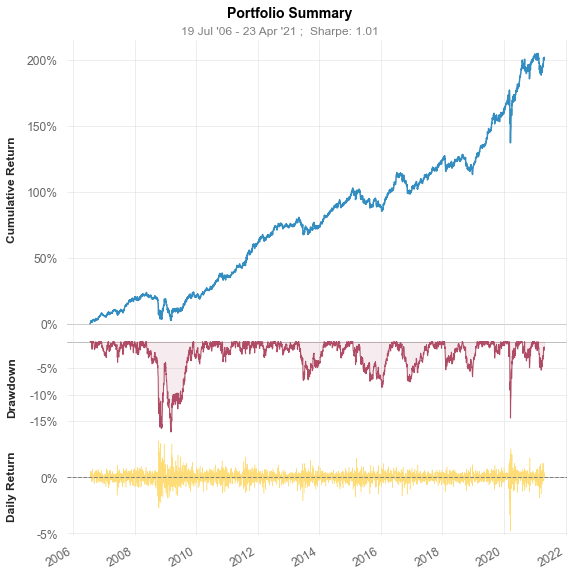

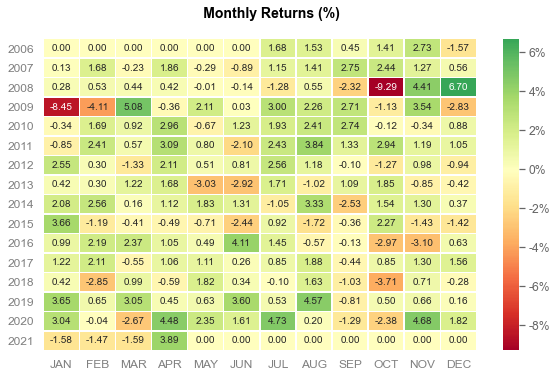

In [6]:
quantstats.reports.plots(df_return['AllSeason_return'], mode='basic')

매일 리밸런싱을 한 결과 연 복리 수익률 7.77%, 샤프 비율 1.01, MDD -17% 정도입니다. 연 변동성도 7.75%로 영구 포트폴리오보다 수익률과 위험 대비 수익이 좋은 아주 좋은 전략입니다.

In [7]:
quantstats.reports.metrics(df_return['AllSeason_return'], mode='full')

                           Strategy
-------------------------  ----------
Start Period               2006-07-20
End Period                 2021-04-23
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          201.83%
CAGR%                      7.77%
Sharpe                     1.01
Sortino                    1.44
Max Drawdown               -17.03%
Longest DD Days            553
Volatility (ann.)          7.75%
Calmar                     0.46
Skew                       -0.36
Kurtosis                   7.51

Expected Daily %           0.03%
Expected Monthly %         0.62%
Expected Yearly %          7.15%
Kelly Criterion            8.99%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.77%
Expected Shortfall (cVaR)  -0.77%

Payoff Ratio               0.97
Profit Factor              1.19
Common Sense Ratio         1.17
CPC Index                  0.64
Tail Ratio                 0.98
Outlier Win Ratio          3.76
Outlier Loss Ratio         3.

위에서 한 것처럼 그냥 만들어도 되지만, 백테스트에 많이 쓰이는 Backtrader 패키지를 한번 사용해 보겠습니다. Input 형식을 맞추어야 합니다.

In [8]:
vti = vti.rename({'vti_Close':'Close'}, axis='columns')
ief = ief.rename({'ief_Close':'Close'}, axis='columns')
tlt = tlt.rename({'tlt_Close':'Close'}, axis='columns')
gld = gld.rename({'gld_Close':'Close'}, axis='columns')
gsg = gsg.rename({'gsg_Close':'Close'}, axis='columns')

for column in ['Open', 'High', "Low"]:
    vti[column] = vti["Close"]
    ief[column] = ief["Close"]
    tlt[column] = tlt["Close"]
    gld[column] = gld["Close"]
    gsg[column] = gsg["Close"]

In [9]:
gsg.head()

,Close,Open,High,Low
Date,,,,
2006-07-21,49.250000,49.250000,49.250000,49.250000
2006-07-24,49.700001,49.700001,49.700001,49.700001
2006-07-25,49.250000,49.250000,49.250000,49.250000
2006-07-26,49.619999,49.619999,49.619999,49.619999
2006-07-27,50.150002,50.150002,50.150002,50.150002


비중을 맞추어 매수하고 20 거래일마다 리밸런싱하는 전략입니다. 20 거래일은 현실 기준으로 약 1개월입니다.

In [13]:
class AssetAllocation_AllSeason(bt.Strategy):
    params = (
        ('equity',0.30),
        ('interbond',0.15),
        ('longbond',0.40),
        ('gold',0.075),
        ('commodity',0.075),
    )
    def __init__(self):
        self.VTI = self.datas[0]
        self.IEF = self.datas[1]
        self.TLT = self.datas[2]
        self.GLD = self.datas[3]
        self.GSG = self.datas[4]
        self.counter = 0
        
    def next(self):
        if  self.counter % 20 == 0:
            self.order_target_percent(self.VTI, target=self.params.equity)
            self.order_target_percent(self.IEF, target=self.params.interbond)
            self.order_target_percent(self.TLT, target=self.params.longbond)
            self.order_target_percent(self.GLD, target=self.params.gold)
            self.order_target_percent(self.GSG, target=self.params.commodity)
        self.counter += 1

In [14]:
cerebro = bt.Cerebro()

cerebro.broker.setcash(1000000)

VTI = bt.feeds.PandasData(dataname = vti)
IEF = bt.feeds.PandasData(dataname = ief)
TLT = bt.feeds.PandasData(dataname = tlt)
GLD = bt.feeds.PandasData(dataname = gld)
GSG = bt.feeds.PandasData(dataname = gsg)

cerebro.adddata(VTI)
cerebro.adddata(IEF)
cerebro.adddata(TLT)
cerebro.adddata(GLD)
cerebro.adddata(GSG)

cerebro.addstrategy(AssetAllocation_AllSeason)

cerebro.addanalyzer(bt.analyzers.PyFolio, _name = 'PyFolio')

results = cerebro.run()
strat = results[0]

portfolio_stats = strat.analyzers.getbyname('PyFolio')
returns, positions, transactions, gross_lev = portfolio_stats.get_pf_items()
returns.index = returns.index.tz_convert(None)

#quantstats.reports.html(returns, output = 'Report_AssetAllocation_AllSeason.html', title='AssetAllocation_AllSeason')

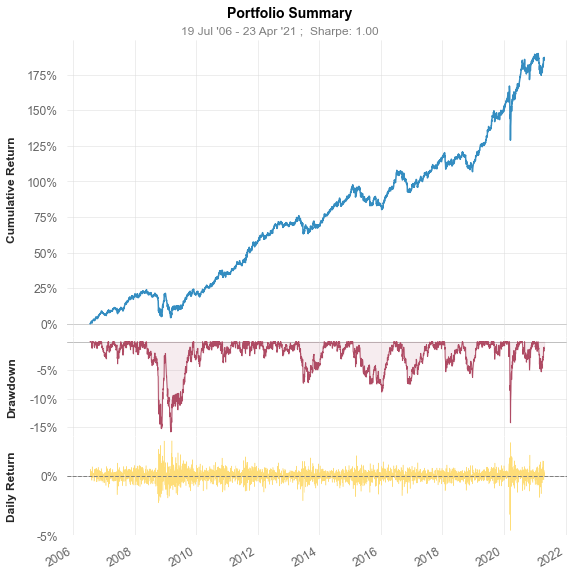

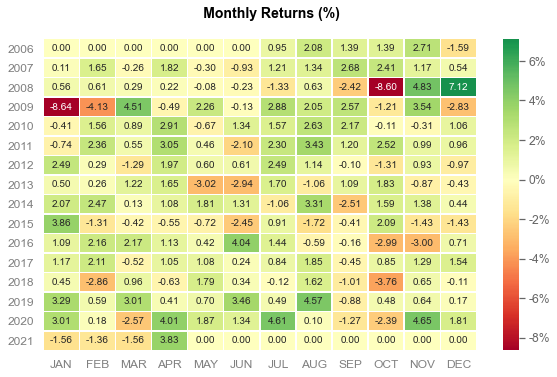

In [15]:
quantstats.reports.plots(returns, mode='basic')

20 거래일마다 리밸런싱으로 바꾸니 연 복리 수익률 7.4%, 샤프 비율 1.0, MDD -16% 수준입니다. 연 변동성 7.4%로 매일 리밸런싱과 큰 차이는 없습니다.

In [16]:
quantstats.reports.metrics(returns, mode='full')

                           Strategy
-------------------------  ----------
Start Period               2006-07-20
End Period                 2021-04-23
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          187.02%
CAGR%                      7.4%
Sharpe                     1.0
Sortino                    1.43
Max Drawdown               -15.85%
Longest DD Days            553
Volatility (ann.)          7.4%
Calmar                     0.47
Skew                       -0.42
Kurtosis                   6.46

Expected Daily %           0.03%
Expected Monthly %         0.59%
Expected Yearly %          6.81%
Kelly Criterion            8.78%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.74%
Expected Shortfall (cVaR)  -0.74%

Payoff Ratio               0.98
Profit Factor              1.19
Common Sense Ratio         1.16
CPC Index                  0.64
Tail Ratio                 0.97
Outlier Win Ratio          3.65
Outlier Loss Ratio         3.66


월간 데이터를 사용하면 훨씬 더 과거의 결과도 테스트해 볼 수 있습니다. 가장 긴 시계열의 경우 1900년 1월부터 2020년 12월까지의 데이터가 있습니다.

In [17]:
MonthlyReturn = pd.read_excel('MonthlyAssetClassReturn.xlsx')

In [18]:
MonthlyReturn.head()

,Data Index,Broker Call Rate,CPI,T-Bills,S&P 500 Total return,Small Cap Stocks,MSCI EAFE,EEM,US 10 YR,US Corp Bond Return Index,...,International Small Cap Value (Global B/M Small Low),International Large Cap Value (Global B/M Big Low),International Small High Mom (Global mom Small High),International Large High Mom (Global mom Small High),Merrill High Yield,World Stocks,World ex USA,BuyWrite,PutWrite,Bitcoin
0,1900-01-31,NaN,0.013333,0.0025,0.016413,NaN,NaN,NaN,0.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1900-02-28,NaN,0.000000,0.0025,0.021138,NaN,NaN,NaN,0.011278,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1900-03-31,NaN,0.000000,0.0025,0.011084,NaN,NaN,NaN,0.009758,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1900-04-30,NaN,0.000000,0.0025,0.015894,NaN,NaN,NaN,-0.016107,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1900-05-31,NaN,0.000000,0.0025,-0.044246,NaN,NaN,NaN,0.016023,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


시계열로 바꾸어 주는 것이 사용하기 편합니다. 1열인 Data Index가 월말 날짜이므로, 이 열을 인덱스로 잡습니다.

In [19]:
MonthlyReturn = MonthlyReturn.set_index('Data Index')

In [20]:
MonthlyReturn.head()

,Broker Call Rate,CPI,T-Bills,S&P 500 Total return,Small Cap Stocks,MSCI EAFE,EEM,US 10 YR,US Corp Bond Return Index,GSCI,...,International Small Cap Value (Global B/M Small Low),International Large Cap Value (Global B/M Big Low),International Small High Mom (Global mom Small High),International Large High Mom (Global mom Small High),Merrill High Yield,World Stocks,World ex USA,BuyWrite,PutWrite,Bitcoin
Data Index,,,,,,,,,,,,,,,,,,,,,
1900-01-31,NaN,0.013333,0.0025,0.016413,NaN,NaN,NaN,0.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1900-02-28,NaN,0.000000,0.0025,0.021138,NaN,NaN,NaN,0.011278,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1900-03-31,NaN,0.000000,0.0025,0.011084,NaN,NaN,NaN,0.009758,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1900-04-30,NaN,0.000000,0.0025,0.015894,NaN,NaN,NaN,-0.016107,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1900-05-31,NaN,0.000000,0.0025,-0.044246,NaN,NaN,NaN,0.016023,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


필요한 것만 뽑아옵니다. 월간 미국 주식(S&P 500), 월간 미국 10년 만기 국채, 월간 미국 30년 만기 국채, 금, 원자재 수익률 데이터입니다. 1970년 1월부터 2020년 12월까지 51년 기간의 테스트가 될 것입니다.

In [21]:
Monthly_AllSeason = MonthlyReturn.loc[:, ['S&P 500 Total return','US 10 YR','US 30 YR','GOLD','GSCI']]
Monthly_AllSeason = Monthly_AllSeason.loc[Monthly_AllSeason.index >= '1970-01-31']
Monthly_AllSeason['Monthly_AllSeason'] = Monthly_AllSeason['S&P 500 Total return']*0.3+Monthly_AllSeason['US 10 YR']*0.15+Monthly_AllSeason['US 30 YR']*0.4+Monthly_AllSeason['GOLD']*0.075+Monthly_AllSeason['GSCI']*0.075

월간 데이터이므로, 일간 데이터 기준인 패키지가 주는 값을 적절히 조정해야 합니다. 1년 12개월 252거래일을 가정합니다. 1970년 1월부터 51년 동안 샤프 비율은 1.162로 나옵니다. Ray Dalio는 확실히 Ray Dalio 입니다. Bridgewater Associates가 사용하는 정교한 모델도 아니고 Tony Robbins와의 인터뷰에서 즉흥에 가깝게 만들어준 모델인데도 과거 성과는 아주 좋습니다. 지금까지 테스트한 전략 중 장기간 샤프 비율이 가장 높은 전략입니다. 아래 그림의 제목 하단에 있는 샤프 비율은 무시하고, 직접 계산한 값을 보아야 합니다.

In [24]:
quantstats.stats.sharpe(Monthly_AllSeason['Monthly_AllSeason'])/math.sqrt(252/12)

1.1622131251236185

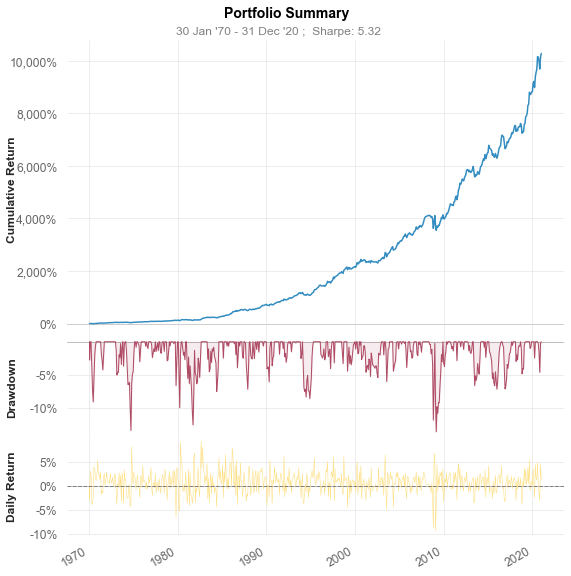

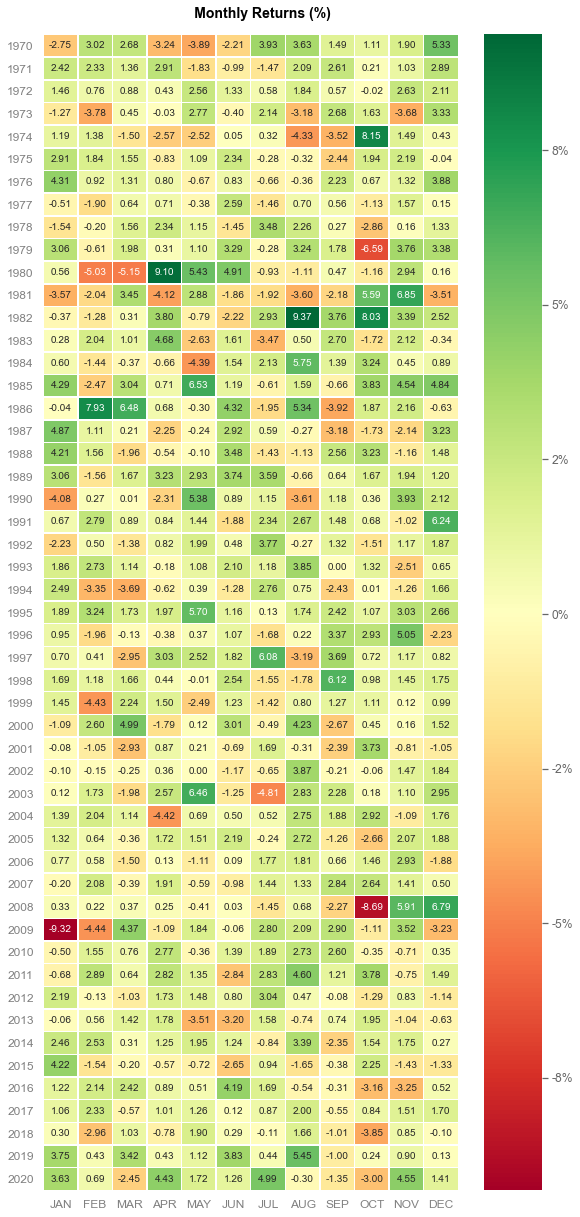

In [25]:
quantstats.reports.plots(Monthly_AllSeason['Monthly_AllSeason'], mode='basic')

연 복리 수익률 9.54%, 샤프 비율은 위에서 계산한대로 1.162 (아래 결과는 무시합니다 월간 데이터라 다르게 나옵니다), MDD는 -13.55%입니다. 방어력, 수익률 무엇 하나 문제되는 것이 없습니다. 원자재가 매우 활약했던 1970년대가 포함되어 성과가 크게 좋아졌습니다. 51년을 버티면 원금이 103배가 됩니다.

In [26]:
quantstats.reports.metrics(Monthly_AllSeason['Monthly_AllSeason'], mode='full')

                           Strategy
-------------------------  ----------
Start Period               1970-01-31
End Period                 2020-12-31
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          10,269.63%
CAGR%                      9.54%
Sharpe                     5.33
Sortino                    9.69
Max Drawdown               -13.55%
Longest DD Days            822
Volatility (ann.)          37.32%
Calmar                     0.7
Skew                       -0.04
Kurtosis                   1.39

Expected Daily %           0.76%
Expected Monthly %         0.76%
Expected Yearly %          9.53%
Kelly Criterion            38.69%
Risk of Ruin               0.0%
Daily Value-at-Risk        -3.08%
Expected Shortfall (cVaR)  -3.08%

Payoff Ratio               1.23
Profit Factor              2.41
Common Sense Ratio         3.43
CPC Index                  1.96
Tail Ratio                 1.42
Outlier Win Ratio          3.31
Outlier Loss Ratio       